In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/jhoward/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem()

In [9]:
from keras.datasets.cifar10 import load_batch

# Densenet / CIFAR 10

From http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [14]:
def load_data():
    path = 'data/cifar-10-batches-py'
    num_train_samples = 50000
    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(path, 'data_batch_' + str(i)))
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels
    x_test, y_test = load_batch(os.path.join(path, 'test_batch'))
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [13]:
(x_train, y_train), (x_test, y_test) = load_data()

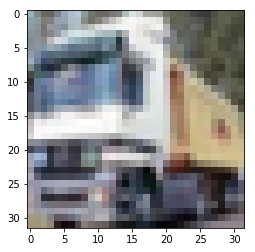

In [17]:
plt.imshow(x_train[1])

In [65]:
x_train = x_train/255.
x_test = x_test/255.

## Densenet

In [112]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x, wd): return BatchNormalization(mode=0, axis=-1, 
                                     gamma_regularizer=l2(0), beta_regularizer=l2(0))(x)
def relu_bn(x, wd): return relu(bn(x, wd))
def conv(x, nf, sz, wd): 
    return Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                          W_regularizer=l2(wd))(x)

In [113]:
def conv_block(ip, nb_filter, bottleneck=False, p=None, wd=0):
    x = relu_bn(ip, wd)
    if bottleneck:
        x = conv(x, nb_filter * 4, 1, wd)
        x = dropout(x,p)
        x = relu_bn(x, wd)
    x = conv(x, nb_filter, 3, wd)
    return dropout(x,p)

In [114]:
def transition_block(ip, nb_filter, compression=1.0, p=None, wd=0):
    x = relu_bn(ip, wd)
    x = conv(x, int(nb_filter * compression), 1, wd)
    x = dropout(x,p)
    return AveragePooling2D((2, 2), strides=(2, 2))(x)

In [115]:
def dense_block(x, nb_layers, nb_filter, growth_rate, bottleneck=False, p=None, wd=0,
                  grow_nb_filters=True):
    for i in range(nb_layers):
        b = conv_block(x, growth_rate, bottleneck, p, wd)
        x = merge([x,b], mode='concat', concat_axis=-1)
        if grow_nb_filters: nb_filter += growth_rate

    return x, nb_filter

### Build the DenseNet model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters. Default -1 indicates initial number of filters is 2 * growth_rate
- nb_layers_per_block: number of layers in each dense block.
  - Can be a -1, positive integer or a list.
  - If -1, calculates nb_layer_per_block from the depth of the network.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided. Note that list size must be (nb_dense_block + 1)
- bottleneck: add bottleneck blocks
- reduction:  reduction factor of transition blocks.  Note : reduction value is inverted to compute compression
- p: dropout rate
- wd: weight decay
- activation: Type of activation at the top layer. Can be one of 'softmax' or 'sigmoid'. Note that if sigmoid is used, classes must be 1.

Returns: keras tensor with nb_layers of conv_block appended

In [116]:
def create_dense_net(nb_classes, img_input, depth=40, nb_dense_block=3, 
     growth_rate=12, nb_filter=-1, nb_layers_per_block=-1, bottleneck=False, 
     reduction=0.0, p=None, wd=0, activation='softmax'):

    concat_axis = -1
    assert (depth - 4) % 3 == 0, "Depth must be 3 N + 4"
    if reduction != 0.0: assert reduction <= 1.0 and reduction > 0.0

    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)  # Convert tuple to list
        assert len(nb_layers) == (nb_dense_block + 1)
        final_nb_layer = nb_layers[-1]
        nb_layers = nb_layers[:-1]
    else:
        if nb_layers_per_block == -1:
            count = int((depth - 4) / 3)
            nb_layers = [count for _ in range(nb_dense_block)]
            final_nb_layer = count
        else:
            final_nb_layer = nb_layers_per_block
            nb_layers = [nb_layers_per_block] * nb_dense_block

    if bottleneck: nb_layers = [int(layer // 2) for layer in nb_layers]
    if nb_filter <= 0: nb_filter = 2 * growth_rate
    compression = 1.0 - reduction

    x = conv(img_input, nb_filter, 3, wd)
    for block_idx in range(nb_dense_block - 1):
        x, nb_filter = dense_block(x, nb_layers[block_idx], nb_filter, growth_rate, 
           bottleneck=bottleneck, p=p, wd=wd)
        x = transition_block(x, nb_filter, compression=compression, p=p, wd=wd)
        nb_filter = int(nb_filter * compression)

    x, nb_filter = dense_block(x, final_nb_layer, nb_filter, growth_rate, 
       bottleneck=bottleneck, p=p, wd=wd)

#     x = relu_bn(x, wd)
    x = GlobalAveragePooling2D()(x)
    
    return Dense(nb_classes, activation=activation, 
                 W_regularizer=l2(wd), b_regularizer=l2(wd))(x)

### Train

In [117]:
input_shape = (32,32,3)

In [118]:
img_input = Input(shape=input_shape)

In [125]:
x = create_dense_net(10, img_input, nb_filter=16, bottleneck=False, p=0.2, wd=1e-4)

In [126]:
model = Model(img_input, x)

In [134]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [135]:
parms = {'verbose': 2, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [131]:
K.set_value(model.optimizer.lr, 1e-2)

In [136]:
model.fit(x_train, y_train, 64, 4, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/4
249s - loss: 2.0307 - acc: 0.3524 - val_loss: 2.1280 - val_acc: 0.3150
Epoch 2/4
237s - loss: 1.4311 - acc: 0.5264 - val_loss: 1.6729 - val_acc: 0.5120
Epoch 3/4
233s - loss: 1.1746 - acc: 0.6239 - val_loss: 1.4312 - val_acc: 0.5790
Epoch 4/4
234s - loss: 1.0510 - acc: 0.6707 - val_loss: 1.7688 - val_acc: 0.5416


In [144]:
K.set_value(model.optimizer.lr, 1e-4)

In [140]:
model.fit(x_train, y_train, 64, 3, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
233s - loss: 0.8462 - acc: 0.7535 - val_loss: 1.3700 - val_acc: 0.6523
Epoch 2/3
234s - loss: 0.7918 - acc: 0.7747 - val_loss: 1.3522 - val_acc: 0.6519
Epoch 3/3
237s - loss: 0.7494 - acc: 0.7937 - val_loss: 1.0653 - val_acc: 0.7269


In [142]:
model.fit(x_train, y_train, 64, 10, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
236s - loss: 0.7201 - acc: 0.8061 - val_loss: 2.1070 - val_acc: 0.5764
Epoch 2/10
237s - loss: 0.6874 - acc: 0.8172 - val_loss: 1.7922 - val_acc: 0.6083
Epoch 3/10
237s - loss: 0.6680 - acc: 0.8250 - val_loss: 0.9055 - val_acc: 0.7550
Epoch 4/10
237s - loss: 0.6486 - acc: 0.8336 - val_loss: 0.9493 - val_acc: 0.7580
Epoch 5/10
237s - loss: 0.6279 - acc: 0.8423 - val_loss: 0.9391 - val_acc: 0.7659
Epoch 6/10
237s - loss: 0.6119 - acc: 0.8484 - val_loss: 0.8636 - val_acc: 0.7873
Epoch 7/10
236s - loss: 0.5997 - acc: 0.8531 - val_loss: 1.2927 - val_acc: 0.7192
Epoch 8/10
237s - loss: 0.5879 - acc: 0.8568 - val_loss: 1.2210 - val_acc: 0.7101
Epoch 9/10
237s - loss: 0.5793 - acc: 0.8621 - val_loss: 0.9683 - val_acc: 0.7615
Epoch 10/10
237s - loss: 0.5672 - acc: 0.8669 - val_loss: 0.7721 - val_acc: 0.8215


In [ ]:
model.fit(x_train, y_train, 64, 10, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
237s - loss: 0.4429 - acc: 0.9095 - val_loss: 0.5508 - val_acc: 0.8828
Epoch 2/10
237s - loss: 0.4101 - acc: 0.9196 - val_loss: 0.5338 - val_acc: 0.8869
Epoch 3/10
237s - loss: 0.3964 - acc: 0.9237 - val_loss: 0.5840 - val_acc: 0.8782
Epoch 4/10
237s - loss: 0.3830 - acc: 0.9281 - val_loss: 0.5715 - val_acc: 0.8820
Epoch 5/10


In [143]:
model.save_weights('models/8215.h5')

## End